<a href="https://colab.research.google.com/github/sajjad-yazdanparast/sentiment_analysis/blob/master/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### I used [this dataset](https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech) for sentiment analysis .
### My task is recognizing speech with sexist and racist sentiment .


In [1]:
from gensim.models import KeyedVectors
import pandas as pd 
import numpy as np 
import nltk 
import spacy
import re
# from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
# from sklearn.naive_bayes import *
# from xgboost import XGBClassifier
from sklearn.metrics import classification_report
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet 
from nltk import word_tokenize, pos_tag
from collections import defaultdict

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
# def gunzip(file_path,output_path):
#     with gzip.open(file_path,"rb") as f_in, open(output_path,"wb") as f_out:
#         shutil.copyfileobj(f_in, f_out)
# gunzip('/content/drive/My Drive/parto tech/ GoogleNews-vectors-negative300.bin.gz','/content/drive/My Drive/parto tech/word2vec.bin')

### I useed pre-trained [google news vectors](https://code.google.com/archive/p/word2vec/) as word2vec model .


In [3]:
model = KeyedVectors.load_word2vec_format(open('/content/drive/My Drive/parto tech/sentiment_analysis/word2vec.bin','rb'), binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [4]:
train = pd.read_csv('/content/drive/My Drive/parto tech/sentiment_analysis/train.csv') 
test = pd.read_csv('/content/drive/My Drive/parto tech/sentiment_analysis/test.csv')

In [5]:
def remove_at_and_hashtag (text) :
  text = text.replace('@user',' ')
  return text.replace('#',' ')
  #TODO : use hashtags

### At cell below I developed functions to lemmatize tokens based on their POS tag using nltk library.

In [6]:
# lemmatizing with NLTK lemmatize


def get_wordnet_pos(pos):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos.upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


lem = WordNetLemmatizer()

def my_lemmatizer (text) :
  tokens = word_tokenize(text)
  lemmatized=[]
  poses = [get_wordnet_pos(tag[0]) for tag in pos_tag(tokens)]
  for i in range (len(tokens)):
    lemma = lem.lemmatize(tokens[i],poses[i])
    lemmatized.append(lemma)
  return ' '.join(lemmatized)


### Below cell contains a block of code for lemmatizing tokens using spacy library. But it's performance was awful, so I commented it !

In [7]:
# def my_lemmtizer(text) :
#   nlp = spacy.load('en', disable=['parser', 'ner'])
#   doc = nlp(text)
#   string = " ".join([token.lemma_ for token in doc])
#   return re.sub('-PRON-','they',string)
 

In [8]:
train['tweet'] = train['tweet'].apply(remove_at_and_hashtag)
train['tweet'] = train['tweet'].apply(my_lemmatizer)

### sentence2vec function creates a vector for each sentence based on the mean of it's words vector. If there was a word which it was not present in the pre-trained word2vec model, I've considered zero vector for that .

In [9]:
def sentence2vec(row,w2v) :
  vector = np.zeros((1,300)) 
  words = row.split()
  count = 0 
  for word in words :
    try :
      vector += w2v[word].reshape((1,300))
      count +=1 
    except KeyError :
      continue 
  if count != 0 :
    return vector/count
  return vector

### Here I applied sentence2vec function to hatred and positive sentences

In [10]:
hated_sentences = train[train['label']==1]['tweet']
positive_sentences = train[train['label']==0]['tweet']
hated_vecs = np.concatenate([sentence2vec(z,model) for z in hated_sentences])
positive_vecs = np.concatenate([sentence2vec(z,model) for z in positive_sentences])

### Plotting cell below is nothing but some data exploratoty

In [11]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt 

# ts = TSNE (2)
# hated_vecs = ts.fit_transform(hated_vecs)
# positive_vecs = ts.fit_transform(positive_vecs)

# for row in positive_vecs :
#   plt.plot(row[0],row[1],marker='o',color='g')
# for row in hated_vecs :
#   plt.plot(row[0],row[1],marker='o',color='r')

### At two cells below I created a dataframe from tweets, their related vectors and labels .

In [12]:
X = np.concatenate((positive_vecs,hated_vecs))
Y = np.concatenate( (np.zeros(len(positive_vecs)) , np.ones(len(hated_vecs))))
tweets = np.concatenate((positive_sentences,hated_sentences))

In [13]:
new_df = pd.DataFrame(X)
new_df['label'] = Y 
new_df['tweet'] = tweets

### Split data into train and test segments then use Linear SVC as model

In [14]:
x_train , x_test , y_train , y_test = train_test_split(new_df.drop(['label','new_label','tweet'],axis=1),new_df['label'],random_state=101,test_size = 0.3)

In [15]:
model_ = LinearSVC(C=5)
model_.fit(x_train,y_train)
y_pred = model_.predict(x_test)

print(classification_report(y_true=y_test,y_pred=y_pred))

### Let's see if there are more than two classes or not.
### Here I used elbow method to find optimal K for clustering

In [18]:
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [19]:
clu = KMeans(n_clusters=5)
clu.fit(X)
new_df['new_label'] = clu.labels_

In [20]:
x_clu_train , x_clu_test , y_clu_train , y_clu_test = train_test_split(new_df.drop(['label','new_label','tweet'],axis=1),new_df['new_label'],random_state=101,test_size = 0.3)

In [21]:
model_clu_ = LinearSVC(C=5)
model_clu_.fit(x_clu_train,y_clu_train)
y_clu_pred = model_clu_.predict(x_clu_test)


print(classification_report(y_true=y_clu_test,y_pred=y_clu_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       308
           1       0.94      0.95      0.94      3245
           2       0.93      0.93      0.93      2891
           3       0.94      0.92      0.93      1384
           4       0.93      0.94      0.93      1761

    accuracy                           0.94      9589
   macro avg       0.95      0.93      0.94      9589
weighted avg       0.94      0.94      0.94      9589



/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Here we can see result of scattering of hatred and positive classes among classes number 0 to 4

In [41]:
gn = new_df.groupby(by=['label','new_label'])[['tweet']].count()
gn

tweet
label new_label       
0.0   0            984
      1          10031
      2           8705
      3           4493
      4           5507
1.0   0              1
      1            862
      2            820
      3             97
      4            462

In [45]:
new_gn =gn.reset_index()

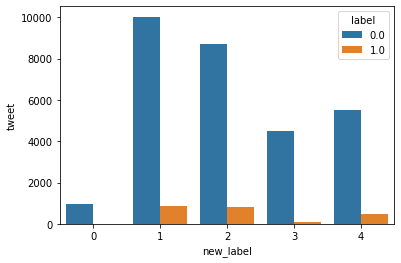

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(x='new_label',y='tweet',hue='label',data=new_gn)